In [1]:
 pip install tf_keras

In [2]:
pip freeze

absl-py==1.4.0
aiohttp==3.9.5
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.15.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.6.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.2
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.1
cryptography==42.0.7
cuda-python==12.2.1
cudf-cu12 @ https://pypi.nvidia.c

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import keras
print(keras.__version__)

2.15.0


In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, Layer,Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization
from tensorflow.keras.activations import linear, relu, sigmoid
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.models import save_model
from tensorflow import keras
from tensorflow.keras import layers,models,Model
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob
import random
from os import listdir
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras.utils as image
from sklearn.preprocessing import LabelEncoder

In [ ]:
path = '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES'
category = os.listdir(path)


data = {"imgpath": [] , "labels": [] }
for cat in category:
    folder = os.path.join(path, cat)
    img_list = os.listdir(folder)
    for img in img_list:
        imgpath = os.path.join(folder, img)
        data['imgpath'].append(imgpath)
        data['labels'].append(cat)
df = pd.DataFrame(data)

In [ ]:
df['labels_clean'] = df['labels'].str.extract(r'\d+\. ([^\d\-]+)')

In [ ]:
encoder = LabelEncoder()
df['encoded_labels'] = encoder.fit_transform(df['labels_clean'])
df['labels_clean'] = df['labels_clean'].str.strip()
print(df.shape)
df.head()

(27153, 4)


,imgpath,labels,labels_clean,encoded_labels
0,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema,3
1,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema,3
2,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema,3
3,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema,3
4,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema,3


In [ ]:
df['labels_clean'] = df['labels_clean'].replace({
    'Basal Cell Carcinoma (BCC)': 'Basal Cell Carcinoma',
    'Melanoma': 'Melanoma',
    'Warts Molluscum and other Viral Infections': 'Viral Skin Infections',
    'Benign Keratosis': 'Benign Keratosis',
    'Psoriasis pictures Lichen Planus and related diseases': 'Psoriasis, Lichen Planus, and related diseases',
    'Melanocytic Nevi (NV)': 'Melanocytic Nevi',
    'Seborrheic Keratoses and other Benign Tumors': 'Seborrheic Keratoses and other Benign Tumors',
    'Tinea Ringworm Candidiasis and other Fungal Infections': 'Fungal Skin Infections',
    'Eczema': 'Eczema',
    'Atopic Dermatitis': 'Atopic Dermatitis'
})

In [ ]:
def undersample_class(df, class_name, sample_size=2000):
    overrepresented_samples = df[df['labels_clean'] == class_name]
    random_list = np.random.choice(overrepresented_samples['imgpath'].tolist(), size=sample_size, replace=False)
    undersampled_overrepresented_samples = overrepresented_samples[overrepresented_samples['imgpath'].isin(random_list)]
    undersampled_overrepresented_samples = undersampled_overrepresented_samples.reset_index(drop=True)

    return pd.concat([df[~(df['labels_clean'] == class_name)], undersampled_overrepresented_samples], ignore_index=True)


classes_to_undersample = ['Melanocytic Nevi']
for class_name in classes_to_undersample:
    df = undersample_class(df, class_name)


In [ ]:
df['labels_clean'].value_counts()

labels_clean
Basal Cell Carcinoma                              3323
Melanoma                                          3140
Viral Skin Infections                             2103
Benign Keratosis                                  2079
Psoriasis, Lichen Planus, and related diseases    2055
Melanocytic Nevi                                  2000
Seborrheic Keratoses and other Benign Tumors      1847
Fungal Skin Infections                            1702
Eczema                                            1677
Atopic Dermatitis                                 1257
Name: count, dtype: int64

In [ ]:
train_df, test_val_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=0)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, shuffle=True, random_state=0)

print(f'train: {len(train_df) / df.shape[0] *100}% | Data(test|val): {len(test_val_df) / df.shape[0] *100}% | test: {len(test_df) / df.shape[0] *100}% | val: {len(val_df) / df.shape[0] *100}% ')

train: 79.998111693339% | Data(test|val): 20.001888306661% | test: 9.998583770004249% | val: 10.003304536656753% 


In [ ]:
train_df = train_df.reset_index(drop=True)
valid_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
def resize(img):
    size = 240
    img = tf.image.resize(img, [size,size])
    img /= 255.
    return img
def my_one_hot(feature, label):
    one_hot = tf.one_hot(label, 10)
    return feature, one_hot
def load_and_preprocess_image(path,label):
    image = tf.io.read_file(path)
    # Decode the image
    if tf.strings.regex_full_match(path, r".*\.png$"):
        image = tf.image.decode_png(image, channels=3)
    else:
        image = tf.image.decode_jpeg(image, channels=3)

    image = resize(image)
    return image, label

In [ ]:
# Training dataset
train_paths = train_df['imgpath'].values
train_labels = train_df['encoded_labels'].values
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(my_one_hot)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation dataset
val_paths = val_df['imgpath'].values
val_labels = val_df['encoded_labels'].values
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(my_one_hot)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Testing dataset
test_paths = test_df['imgpath'].values
test_labels = test_df['encoded_labels'].values
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(my_one_hot)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#plot
train_paths = train_df['imgpath'].values
train_labels = train_df['encoded_labels'].values
x = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
x = x.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

images = []
labels = []
for img, label in x.take(4):
    images.append(img)
    labels.append(label.numpy())

#for i in range(4):
#    plt.subplot(2,2,i+1)
#    plt.imshow(images[i])
#    plt.title(labels[i])
#plt.tight_layout()

In [5]:
import tensorflow_hub as hub

In [ ]:
eff_v2_xl = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet21k-ft1k-b1-feature-vector/1"

In [ ]:
feature_extractor_layer = hub.KerasLayer(eff_v2_xl,
                                              trainable=False,
                                              name='feature_extraction_layer',
                                              input_shape=(240,240,3))

Attaching model 'google/efficientnet-v2/tensorflow2/imagenet21k-ft1k-b1-feature-vector/1' to your Kaggle notebook...


In [ ]:
#pretrained_model = tf.keras.applications.EfficientNetB5(
#    input_shape=(224, 224, 3),
#    include_top=False, # we don`t need a pre-trained top layer (output layer)
#    weights='imagenet',
#    pooling='max',
    #include_preprocessing=True
#)

In [ ]:
"""
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

for i, layer in enumerate(pretrained_model.layers[-3:]):
    pretrained_model.layers[i].trainable = True
        """

In [ ]:
class Savemodel(Callback):
    def __init__(self, filepath, monitor='val_accuracy', verbose=1, save_best_only=True):
        super(Savemodel, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_val_acc = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get(self.monitor)
        if current_val_acc > self.best_val_acc:
            if self.verbose > 0:
                print(f"\nValidation accuracy improved from {self.best_val_acc:.5f} to {current_val_acc:.5f}. Saving model.")
            self.best_val_acc = current_val_acc
            save_model(self.model, self.filepath, overwrite=True)
        else:
            if self.verbose > 0:
                print(f"\nValidation accuracy did not improve from {self.best_val_acc:.5f}.")

callbacks  = [Savemodel(filepath='best_model.h5')]

In [ ]:
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomZoom(0.15),
  layers.experimental.preprocessing.RandomContrast(0.15),
  layers.experimental.preprocessing.RandomRotation(0.15),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
], name='AugmentationLayer')



inputs = layers.Input(shape = (240,240,3), name='inputLayer')
x = augment(inputs)
pretrain_out = feature_extractor_layer(x, training = False)

x = layers.Dense(16)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)

x = layers.Dense(10)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)

# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 240, 240, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 240, 240, 3)       0         
 ial)                                                            
                                                                 
 feature_extraction_layer (  (None, 1280)              6931124   
 KerasLayer)                                                     
                                                                 
 dense (Dense)               (None, 16)                20496     
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 batch_normalization (Batch  (None, 16)                64    

In [ ]:
for layer in model.layers[:-5]:
    layer.trainable = True

In [ ]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_dataset,
                   validation_data=val_dataset,
                   epochs=30,
                   callbacks=[callbacks])

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_dataset,
                   validation_data=val_dataset,
                   epochs=40,
                   callbacks=[callbacks])

In [ ]:
model.evaluate(test_dataset)

In [ ]:
my_reloaded_model = tf.keras.models.load_model(
       ('/kaggle/input/model2/tensorflow2/h5/1/best_model (1) (1).h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

Attaching model 'google/efficientnet-v2/tensorflow2/imagenet21k-ft1k-b1-feature-vector/1' to your Kaggle notebook...


In [ ]:
my_reloaded_model.evaluate(test_dataset)

67/67 [==============================] - 11s 143ms/step - loss: 0.6710 - accuracy: 0.8263


[0.6709783673286438, 0.826251208782196]

# classification report

In [ ]:
from sklearn.metrics import classification_report

predictions = my_reloaded_model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

labels = ['Eczema', 'Viral Skin Infections', 'Basal Cell Carcinoma',
          'Psoriasis, Lichen Planus, and related diseases',
          'Fungal Skin Infections', 'Atopic Dermatitis', 'Benign Keratosis',
          'Seborrheic Keratoses and other Benign Tumors', 'Melanoma',
          'Melanocytic Nevi']

report = classification_report(test_labels, predicted_classes, target_names=labels)
print(report)



67/67 [==============================] - 6s 82ms/step
                                                precision    recall  f1-score   support

                                        Eczema       0.57      0.72      0.64       126
                         Viral Skin Infections       0.96      0.93      0.94       322
                          Basal Cell Carcinoma       0.83      0.92      0.87       217
Psoriasis, Lichen Planus, and related diseases       0.68      0.57      0.62       183
                        Fungal Skin Infections       0.90      0.89      0.90       192
                             Atopic Dermatitis       1.00      0.97      0.98       343
                              Benign Keratosis       0.77      0.69      0.73       196
  Seborrheic Keratoses and other Benign Tumors       0.89      0.69      0.78       183
                                      Melanoma       0.73      0.76      0.75       153
                              Melanocytic Nevi       0.70      0.

# predict with treshold

In [ ]:
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
label_mapping

{'Atopic Dermatitis ': 0,
 'Basal Cell Carcinoma (BCC) ': 1,
 'Benign Keratosis': 2,
 'Eczema ': 3,
 'Melanocytic Nevi (NV) ': 4,
 'Melanoma ': 5,
 'Psoriasis pictures Lichen Planus and related diseases ': 6,
 'Seborrheic Keratoses and other Benign Tumors ': 7,
 'Tinea Ringworm Candidiasis and other Fungal Infections ': 8,
 'Warts Molluscum and other Viral Infections ': 9}

In [ ]:
img_new = '/kaggle/input/comppp/download (31).jpg'
img_new = load_pred(img_new)
a = my_reloaded_model.predict(tf.expand_dims(img_new, axis=0))
a

1/1 [==============================] - 0s 28ms/step


array([[0.02966462, 0.09336808, 0.00975388, 0.02258288, 0.5461753 ,
        0.06366309, 0.05965379, 0.16079593, 0.00442763, 0.00991479]],
      dtype=float32)

In [ ]:
 for i, prob in enumerate(a[0]):
        print(prob)

0.029664623
0.093368076
0.009753881
0.022582876
0.5461753
0.06366309
0.05965379
0.16079593
0.0044276346
0.009914793


In [ ]:
recall_scores = {
    'Atopic Dermatitis ': 0.97,
    'Basal Cell Carcinoma (BCC) ': 0.92,
    'Benign Keratosis': 0.69,
    'Eczema ': 0.72,
    'Melanocytic Nevi (NV) ': 0.86,
    'Melanoma ': 0.76,
    'Psoriasis pictures Lichen Planus and related diseases ': 0.57,
    'Seborrheic Keratoses and other Benign Tumors ': 0.69,
    'Tinea Ringworm Candidiasis and other Fungal Infections ': 0.89,
    'Warts Molluscum and other Viral Infections ': 0.93
}

tresh_dict = {}
for label, recall in recall_scores.items():
    tresh_dict[label] = recall - 0.05

tresh_dict

{'Atopic Dermatitis ': 0.9199999999999999,
 'Basal Cell Carcinoma (BCC) ': 0.87,
 'Benign Keratosis': 0.6399999999999999,
 'Eczema ': 0.6699999999999999,
 'Melanocytic Nevi (NV) ': 0.8099999999999999,
 'Melanoma ': 0.71,
 'Psoriasis pictures Lichen Planus and related diseases ': 0.5199999999999999,
 'Seborrheic Keratoses and other Benign Tumors ': 0.6399999999999999,
 'Tinea Ringworm Candidiasis and other Fungal Infections ': 0.84,
 'Warts Molluscum and other Viral Infections ': 0.88}

In [ ]:
def predict_with_thresholds(model, image, thresholds):

    image = load_pred(image)
    probabilities = model.predict(tf.expand_dims(image, axis=0))

    class_labels = [
        'Atopic Dermatitis ',
        'Basal Cell Carcinoma (BCC) ',
        'Benign Keratosis',
        'Eczema ',
        'Melanocytic Nevi (NV) ',
        'Melanoma ',
        'Psoriasis pictures Lichen Planus and related diseases ',
        'Seborrheic Keratoses and other Benign Tumors ',
        'Tinea Ringworm Candidiasis and other Fungal Infections ',
        'Warts Molluscum and other Viral Infections '
    ]


    for i, prob in enumerate(probabilities[0]):
        class_label = class_labels[i]
        if prob >= thresholds.get(class_label, 1):  # Default threshold of 1
            return class_label, prob

    return "Sorry, we don't have the data yet"

img_new = '/kaggle/input/comppp/download (31).jpg'
predict_with_thresholds(my_reloaded_model, img_new, tresh_dict)


1/1 [==============================] - 0s 31ms/step


"Sorry, we don't have the data yet"

# Plot

In [ ]:
import seaborn as sns
def plot(history):
    trn_loss = history.history['loss']
    val_loss = history.history['val_loss']

    trn_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epoch = range(len(history.history['loss']))

    f, ax = plt.subplots(1,2,figsize=(12,8))
    #train
    sns.lineplot(x=epoch, y=trn_acc, label='train_acc', ax=ax[0])
    sns.lineplot(x=epoch, y=val_acc, label='val_acc', ax=ax[0])

    #validation
    sns.lineplot(x=epoch, y=trn_loss, label='trn_loss', ax=ax[1])
    sns.lineplot(x=epoch, y=val_loss, label='val_loss', ax=ax[1])


    plt.show()
plot(history)

In [9]:
def load_pred(imgpath, imgsize=240):
    img = tf.io.read_file(imgpath)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (imgsize,imgsize))
    img = img/255.
    return img

In [8]:
def load_pred(imgpath, imgsize=240):
    img = tf.io.read_file(imgpath)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (imgsize,imgsize))
    img = img/255.
    return img

def preds(model, test_df=test_df, label_mapping=label_mapping):
    random_img = test_df['imgpath'].sample(10)
    for i in range(10):
        img = load_pred(random_img.iloc[i])
        pred = model.predict(tf.expand_dims(img, axis=0))
        pred_class_encoded = np.argmax(pred)
        pred_labels = [label for label, value in label_mapping.items() if pred_class_encoded == value]  # Use pred instead of preds

        actual_index = random_img.index[i]
        actual_label_encoded = test_df['encoded_labels'].iloc[actual_index]
        actual_label = test_df['labels_clean'].iloc[actual_index]

        print("Predicted label for image", i+1, ":", pred_labels)

        if pred_class_encoded != actual_label_encoded:
            print(f"Predicted wrong! | Actual label is {actual_label}")

NameError: name 'test_df' is not defined

In [ ]:
preds(my_reloaded_model)

1/1 [==============================] - 0s 323ms/step
predicted as: Benign Keratosis


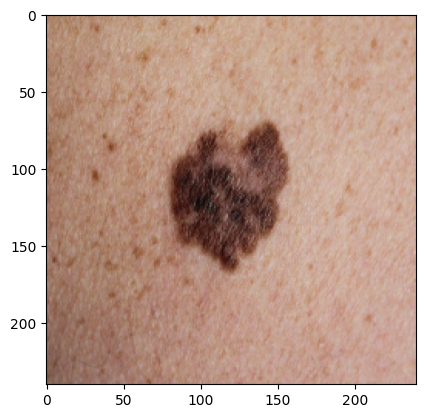

In [16]:
img_new = '/content/istockphoto-1260533084-612x612.jpg'
img_new = load_pred(img_new)
img_new_pred = my_reloaded_model.predict(tf.expand_dims(img_new, axis=0))
img_new_pred = np.argmax(img_new_pred)
for label, value in label_mapping.items():
    if img_new_pred == value:
        print(f'predicted as: {label}')

plt.imshow(img_new)

In [ ]:
print('s')

In [7]:
my_reloaded_model = tf.keras.models.load_model(
       ('/content/best_model.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [12]:
label_mapping = {'Atopic Dermatitis ': 0,
 'Basal Cell Carcinoma (BCC) ': 1,
 'Benign Keratosis': 2,
 'Eczema ': 3,
 'Melanocytic Nevi (NV) ': 4,
 'Melanoma ': 5,
 'Psoriasis pictures Lichen Planus and related diseases ': 6,
 'Seborrheic Keratoses and other Benign Tumors ': 7,
 'Tinea Ringworm Candidiasis and other Fungal Infections ': 8,
 'Warts Molluscum and other Viral Infections ': 9}